In [116]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

start_date = "2010-01-05"
data_tsmc = yf.download("2330.TW", start=start_date, end=None, interval="1d")
data_nvidia = yf.download("NVDA", start=start_date, end=None, interval="1d")
data_amd = yf.download("AMD", start=start_date, end=None, interval="1d")
data_tsmc.columns = ['_'.join(col).strip() for col in data_tsmc.columns.to_flat_index()]
data_nvidia.columns = ['_'.join(col).strip() for col in data_nvidia.columns.to_flat_index()]
data_amd.columns = ['_'.join(col).strip() for col in data_amd.columns.to_flat_index()]
series_col = 'Close_2330.TW'
data_tsmc.columns

C:\Users\user\AppData\Local\Temp\ipykernel_22624\2603232090.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_tsmc = yf.download("2330.TW", start=start_date, end=None, interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_22624\2603232090.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_nvidia = yf.download("NVDA", start=start_date, end=None, interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_22624\2603232090.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_amd = yf.download("AMD", start=start_date, end=None, interval="1d")
[*********************100%***********************]  1 of 1 completed


Index(['Close_2330.TW', 'High_2330.TW', 'Low_2330.TW', 'Open_2330.TW',
       'Volume_2330.TW'],
      dtype='object')

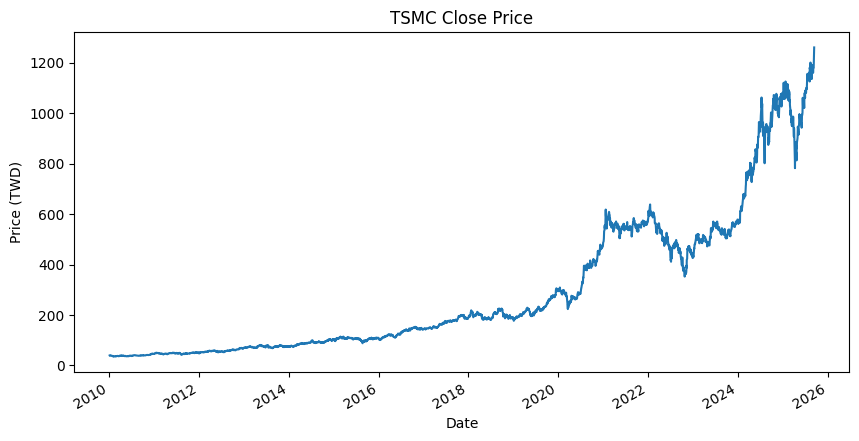

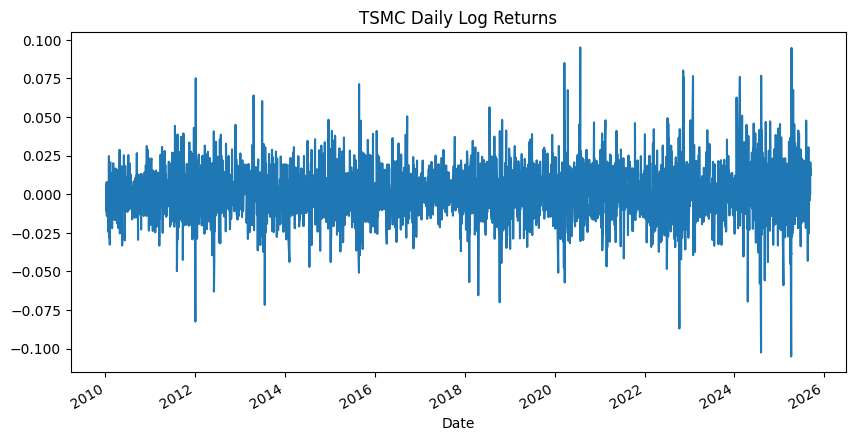

In [100]:
fig, ax = plt.subplots(figsize=(10,5))
data_tsmc[series_col].plot(ax=ax)
ax.set_title("TSMC Close Price")
ax.set_ylabel("Price (TWD)")
plt.show()

# Daily log returns
data_tsmc['log_return'] = np.log(data_tsmc[series_col]).diff()
data_tsmc['log_return'].plot(figsize=(10,5), title="TSMC Daily Log Returns")
plt.show()

Check log return to see trend, volatility clusters, and whether returns look stationary.

Check autocorrelation characteristics of the columns

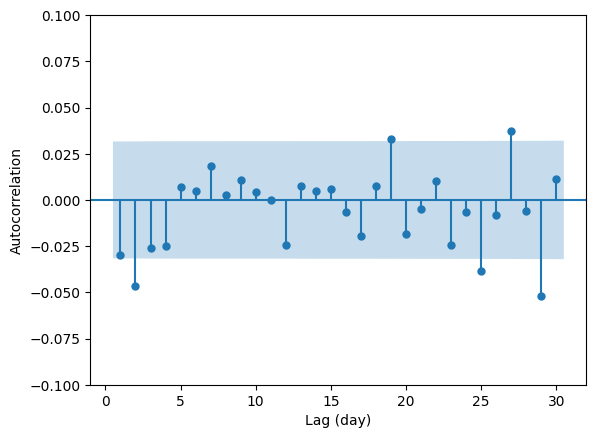

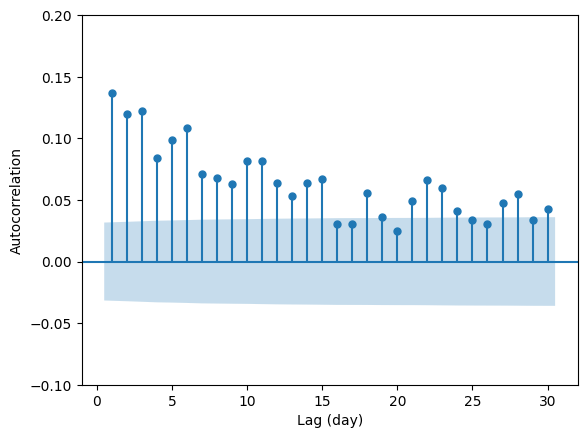

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_lags = 30
plot_acf(data_tsmc['log_return'].dropna(), lags=plot_lags, zero=False)
plt.title("")
plt.ylabel("Autocorrelation")
plt.xlabel("Lag (day)")
plt.ylim(-0.1, 0.1)
plt.show()
plot_acf(data_tsmc['log_return'].dropna().abs(), lags=plot_lags, zero=False)
plt.ylabel("Autocorrelation")
plt.xlabel("Lag (day)")
plt.title("")
plt.ylim(-0.1, 0.2)
plt.show()

In [130]:
data = data_tsmc[[series_col]]

# Yesterday's return (as before)
data["Return_2330.TW(yesterday)"] = np.log(data[series_col] / data[series_col].shift(1)).shift(1)

# Yesterday's actual closing price
data["Close_2330.TW(yesterday)"] = data_tsmc[series_col].shift(1)

# Yesterday's volume
data["Volume_2330.TW(yesterday)"] = data_tsmc["Volume_2330.TW"].shift(1)


# ---- NVDA ----
data["Return_NVDA(yesterday)"] = np.log(data_nvidia["Close_NVDA"] / data_nvidia["Close_NVDA"].shift(1)).shift(1)
data["Close_NVDA(yesterday)"]  = data_nvidia["Close_NVDA"].shift(1)
data["Volume_NVDA(yesterday)"] = data_nvidia["Volume_NVDA"].shift(1)


# ---- AMD ----
data["Return_AMD(yesterday)"] = np.log(data_amd["Close_AMD"] / data_amd["Close_AMD"].shift(1)).shift(1)
data["Close_AMD(yesterday)"]  = data_amd["Close_AMD"].shift(1)
data["Volume_AMD(yesterday)"] = data_amd["Volume_AMD"].shift(1)
exog_cols = [col for col in data.columns if col not in["Date","Close_2330.TW"]]


C:\Users\user\AppData\Local\Temp\ipykernel_22624\3619908586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return_2330.TW(yesterday)"] = np.log(data[series_col] / data[series_col].shift(1)).shift(1)
C:\Users\user\AppData\Local\Temp\ipykernel_22624\3619908586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close_2330.TW(yesterday)"] = data_tsmc[series_col].shift(1)
C:\Users\user\AppData\Local\Temp\ipykernel_22624\3619908586.py:10: SettingWithCopyWarning: 
A value is trying to be set on a

In [138]:
print(data.columns)
data.to_csv("raw_data.csv")

Index(['Close_2330.TW', 'Return_2330.TW(yesterday)',
       'Close_2330.TW(yesterday)', 'Volume_2330.TW(yesterday)',
       'Return_NVDA(yesterday)', 'Close_NVDA(yesterday)',
       'Volume_NVDA(yesterday)', 'Return_AMD(yesterday)',
       'Close_AMD(yesterday)', 'Volume_AMD(yesterday)'],
      dtype='object')


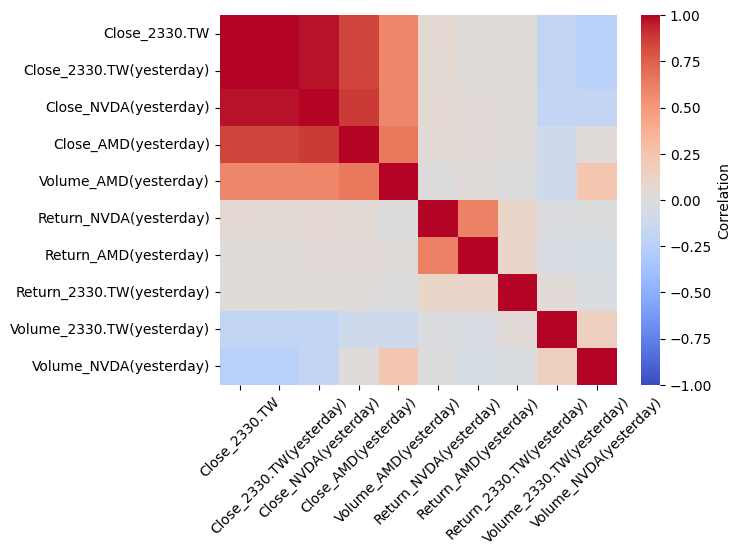

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = [col for col in data.columns if col not in ["Date","is_weekend","log_return"]]
corr_matrix = data[corr_cols].corr(method="spearman")

# sort by correlation with the target series
order = corr_matrix[series_col].sort_values(ascending=False).index

sns.heatmap(
    corr_matrix.loc[order, order],   # reindex both rows and columns
    annot=False, fmt=".2f", cmap="coolwarm",
    vmin=-1, vmax=1,
    cbar_kws={"label": "Correlation"}
)
plt.xticks(rotation=45)
plt.show()


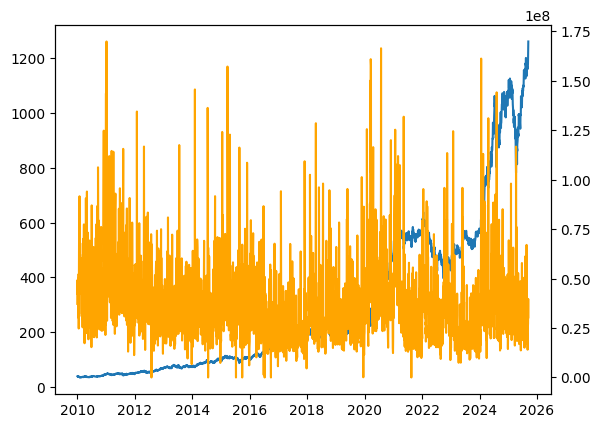

In [127]:
fig, ax1 = plt.subplots()
ax1.plot(data.index, data[series_col], label="Target")
ax2 = ax1.twinx()
ax2.plot(data.index, data[exog_cols[1]], color='orange', label="Exogenous")


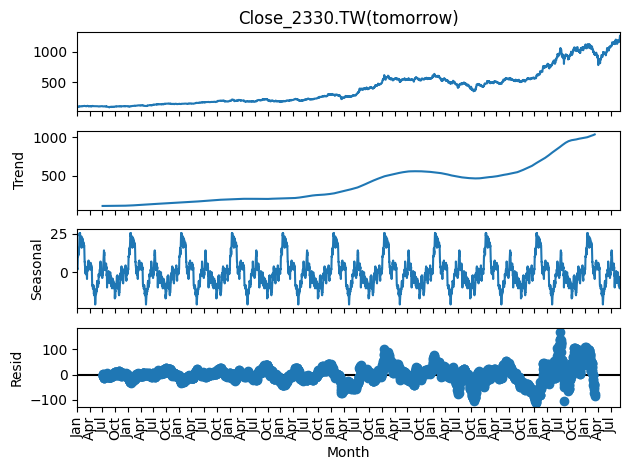

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

result = seasonal_decompose(data[series_col], model='additive', period=365)
fig = result.plot()

for ax in fig.axes:
    # Show one tick for each month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
    # Format as month number (1–12) or month name
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' for Jan, Feb...
    ax.tick_params(axis='x', rotation=90)
plt.xlabel("Month")
plt.tight_layout()
plt.show()


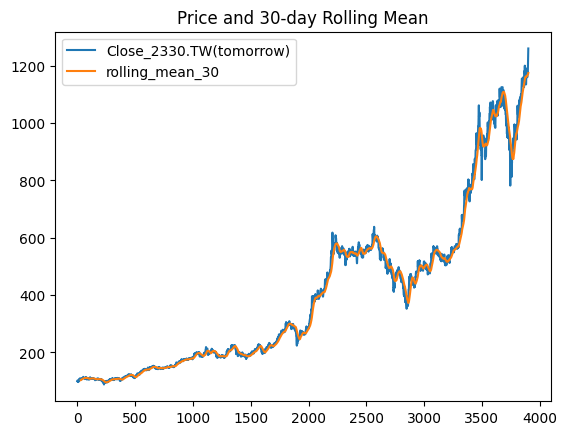

In [78]:
data['rolling_mean_30'] = data[series_col].rolling(30).mean()
data['rolling_std_30']  = data[series_col].rolling(30).std()

data[[series_col,'rolling_mean_30']].plot(title="Price and 30-day Rolling Mean")
# data['rolling_std_30'].plot(title="30-day Rolling Volatility")
plt.legend()
plt.show()

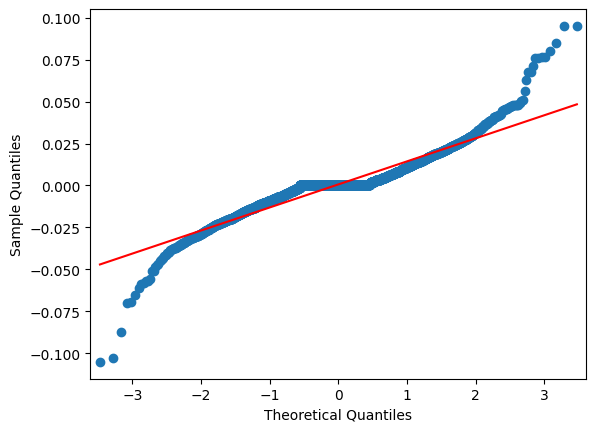

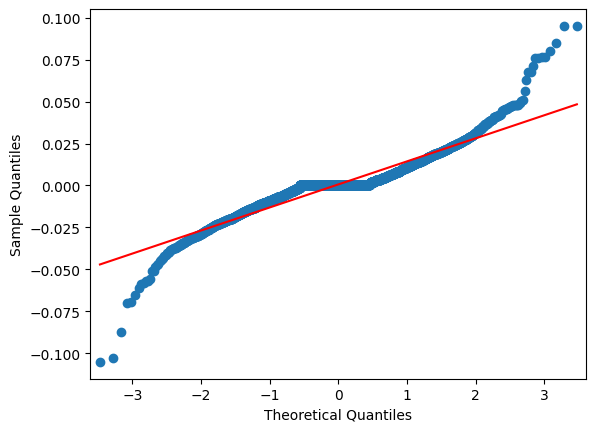

In [79]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data['log_return'].dropna(), line='s')